In [79]:
import os
import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import re
import pickle
import vector
import mplhep as hep
import math
from tabulate import tabulate
from collections import defaultdict

vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)

matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'

In [80]:
# parameters
input_label = 'feb28'
output_label = 'outputs/feb28'
file_ext = '.pdf'
selections = ['ch']
plotDir = os.getcwd()
inputDir = '/home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/'
datasets = os.listdir(inputDir)
infile_names = [inputDir+dataset for dataset in datasets]

Some functions from plotting/plot.ipynb from the SUEPCoffea_dask repo.

In [213]:
default_colors = {
    'QCD': 'midnightblue',
    'SUEP-m1000-darkPho': 'red',
    'SUEP-m1000-darkPhoHad': 'red',
    'SUEP-m1000-generic': 'red',
    'SUEP-m750-darkPho': 'orange',
    'SUEP-m750-darkPhoHad': 'orange',
    'SUEP-m750-generic': 'orange',
    'SUEP-m400-darkPho': 'green',
    'SUEP-m400-darkPhoHad': 'green',
    'SUEP-m400-generic': 'green',
    'SUEP-m125-darkPho': 'cyan',
    'SUEP-m125-darkPhoHad': 'cyan',
    'SUEP-m125-generic': 'cyan',
        
}


# function to load files from pickle
def openpkl(infile_name):
    plots={}
    with (open(infile_name, "rb")) as openfile:
        while True:
            try:
                plots.update(pickle.load(openfile))
            except EOFError:
                break
    return plots

def plot1d(h, ax, label, color='default', lw=1):
    
    if color == 'default': color = default_colors[label]
    if label == 'QCD' and lw==1: lw=3
    
    y, x = h.to_numpy()
    e = np.sqrt(h.variances())
    x = x[:-1]
    
    #ax.step(x[:-1],values, label=label, color=color, lw=lw)
    ax.errorbar(x, y, yerr=e, label=label, lw=lw, color=color, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
            
def plot1d_bins(h, ax, label, bins, color='default', lw=1):
    
    if color == 'default': color = default_colors[label]
    if label == 'QCD' and lw==1: lw=3
    
    x, y, e = [], [], []
    for ibin in range(len(bins) - 1):
        bin_l = bins[ibin]
        bin_u = bins[ibin+1]
        value, err = get_slice(h, bin_l, bin_u)
        y.append(value)
        e.append(err)
        x.append((bin_u + bin_l)/2)
        
    ax.errorbar(x, y, yerr=np.sqrt(e), label="_nolegend_", marker='|', color=color, lw=0)
    ax.hist(x, bins=bins, weights=y, label=label, lw=lw, color=color, histtype='step')
    ax.set_ylabel("Events")
    
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
def D_expect(plots, selection):
    sizeC = plots['C_' + selection].sum()
    sizeA = plots['A_' + selection].sum()
    Bhist = plots['B_' + selection]
    if sizeA.value > 0:
        D_exp = Bhist * sizeC.value / sizeA.value
    else: #Cannot properly predict D without any events in A
        D_exp = Bhist * 0.0
    return D_exp

In [82]:
# dimensions: (real or MC) x (plot label) x (value or error on the value)
stats = nested_dict(4,float)

# dimensions: (real or MC) x (plot label)
plots = {}

# load file(s)
for infile_name in infile_names:
    if not os.path.isfile(infile_name): print("WARNING:",infile_name,"doesn't exist")
    elif input_label not in infile_name: continue
    elif ".pkl" not in infile_name: continue
    else:
        print("Loading",infile_name)
        
        if 'QCD_Pt' in infile_name: 
            plots[infile_name.split('/')[-1].split('.pkl')[0]] = openpkl(infile_name)
            sample = 'QCD_MC'
        elif 'JetHT+Run' in infile_name: 
            sample = 'data'
        elif 'SUEP' in infile_name:
            sample = infile_name.split('/')[-1].split('+')[0]
        else: 
            sample = infile_name.split('/')[-1].split('.pkl')[0]
                
        if sample not in list(plots.keys()): 
            plots[sample] = openpkl(infile_name)
        else:
            plotsToAdd = openpkl(infile_name) 
            for plot in list(plotsToAdd.keys()):
                plots[sample][plot]  = plots[sample][plot] + plotsToAdd[plot]
                

for selection in selections:
        plots['QCD_MC']['D_exp_' + selection] = D_expect(plots['QCD_MC'],selection)
        plots['data']['D_exp_' + selection] = D_expect(plots['data'],selection)

Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/SUEP-m1000-darkPho+RunIIAutumn18-private+MINIAODSIM_feb28.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_feb28.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM_feb28.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_feb28.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_feb28.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16

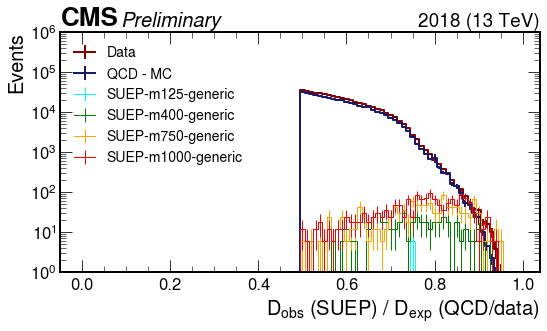

In [83]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
sample = 'generic'
save = False
lumi = 61000

# define figure, axis on which to plot QCD and SUEP
fig, ax = plt.subplots(figsize=(8,5))
hep.cms.label("Preliminary", data=True, year=2018)

# QCD hist for ABCD region
hdata = plots['data']['D_exp_ch']
hQCD_MC = plots['QCD_MC']['D_exp_ch'] * lumi
hM125 = plots['SUEP-m125-generic']['D_obs_ch'] * lumi
hM400 = plots['SUEP-m400-generic']['D_obs_ch'] * lumi
hM700 = plots['SUEP-m750-generic']['D_obs_ch'] * lumi
hM1000 = plots['SUEP-m1000-generic']['D_obs_ch'] * lumi

# plot QCD, sum values and errs
plot1d(hdata, ax, 'Data', color='maroon', lw=2)
plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=2)
plot1d(hM125, ax, 'SUEP-m125-generic', lw=1)
plot1d(hM400, ax, 'SUEP-m400-generic', lw=1)
plot1d(hM700, ax, 'SUEP-m750-generic', lw=1)
plot1d(hM1000, ax, 'SUEP-m1000-generic', lw=1)

ax.set_ylim(1e0,1e6)
ax.set_yscale('log')
ax.set_xlabel(r"$D_{obs}$ (SUEP) / $D_{exp}$ (QCD/data)")
ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)

if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()

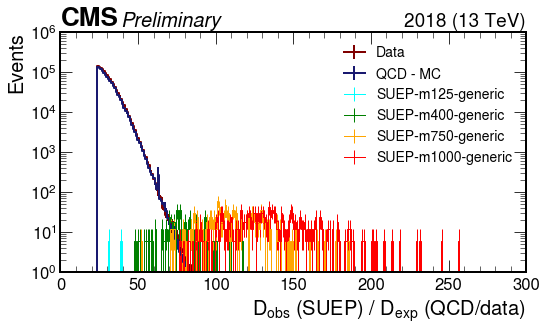

In [140]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
sample = 'generic'
save = False
lumi = 61000

# define figure, axis on which to plot QCD and SUEP
fig, ax = plt.subplots(figsize=(8,5))
hep.cms.label("Preliminary", data=True, year=2018)

# QCD hist for ABCD region
hdata = plots['data']['D_exp_var2_ch']
hQCD_MC = plots['QCD_MC']['D_exp_var2_ch'] * lumi
hM125 = plots['SUEP-m125-generic']['D_obs_var2_ch'] * lumi
hM400 = plots['SUEP-m400-generic']['D_obs_var2_ch'] * lumi
hM700 = plots['SUEP-m750-generic']['D_obs_var2_ch'] * lumi
hM1000 = plots['SUEP-m1000-generic']['D_obs_var2_ch'] * lumi

# plot QCD, sum values and errs
plot1d(hdata, ax, 'Data', color='maroon', lw=2)
plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=2)
plot1d(hM125, ax, 'SUEP-m125-generic', lw=1)
plot1d(hM400, ax, 'SUEP-m400-generic', lw=1)
plot1d(hM700, ax, 'SUEP-m750-generic', lw=1)
plot1d(hM1000, ax, 'SUEP-m1000-generic', lw=1)

ax.set_xlim(0,300)
ax.set_ylim(1e0,1e6)
ax.set_yscale('log')
ax.set_xlabel(r"$D_{obs}$ (SUEP) / $D_{exp}$ (QCD/data)")
ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)

if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()

In [110]:
def get_slice(h, bin_l, bin_u):
    y, x = h.to_numpy()
    x = x[:-1]
    e = h.variances()
    
    bin_slice = (x > bin_l) & (x < bin_u)
    value = np.sum(y[bin_slice])
    variance = np.sum(e[bin_slice])
    
    return value, variance

def poisson_interval(k, alpha=0.05): 
    """
    uses chisquared info to get the poisson interval. Uses scipy.stats 
    (imports in function). 
    """
    from scipy.stats import chi2
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return low, high

def calc_significance(hBkg, hSignal, bins=[0.5,0.6,0.7,0.8,0.9,1.0]):
    sigs = np.array([])
    for ibin in range(len(bins) - 1):
        bin_l = bins[ibin]
        bin_u = bins[ibin+1]

        bkg, s_bkg = get_slice(hBkg, bin_l, bin_u)
        signal, s_signal = get_slice(hSignal, bin_l, bin_u)
    
        if signal + bkg + s_signal + s_bkg == 0: sig = 0
        else: sig = signal / np.sqrt(signal + bkg + np.sqrt(s_signal) + np.sqrt(s_bkg))
        
        sigs = np.append(sigs, sig)
        
    sig = np.sqrt(np.sum(sigs**2))
    return sig

In [111]:
hdata = plots['data']['D_exp_var2_ch']
hQCD_MC = plots['QCD_MC']['D_exp_var2_ch'] * lumi
hM125 = plots['SUEP-m125-generic']['D_obs_var2_ch'] * lumi
hM400 = plots['SUEP-m400-generic']['D_obs_var2_ch'] * lumi
hM700 = plots['SUEP-m750-generic']['D_obs_var2_ch'] * lumi
hM1000 = plots['SUEP-m1000-generic']['D_obs_var2_ch'] * lumi

calc_significance(hQCD_MC, hM400, np.linspace(25,300,20))

15.658008942935666

Try different sets of bins to optimize the significance.

In [133]:
# sets = [
#     np.linspace(0.5,1.0,5),
#     np.linspace(0.5,1.0,10),
#     np.linspace(0.5,1.0,20),
#     np.linspace(0.5,1.0,40),
#     np.linspace(0.5,1.0,80),
#     np.linspace(0.5,1.0,1000),
#     [0.5,0.75,0.8,0.85,0.9,0.95,1.0],
# ]
sets = [
    np.linspace(25,300,20),
    np.linspace(25,300,40),
    np.linspace(25,300,80),
    [ 25,  30,  40,  50,  60,  70, 100, 300],
    [ 25,  30,  40,  50,  60,  70, 300] # the optimized one from below
]
for bins in sets:
    print(calc_significance(hQCD_MC, hM400, bins))

15.658008942935666
15.579801087739046
15.050462815545028
16.047019782773734
16.189573925480207


Optimize the bin placements automatically. <br>
This code will check (# intervals) choose (# bins) values, so this code will only work for small number of intervals and bins.

In [130]:
import itertools
from math import comb

n_intervals = 20
n_bins = 4
intervals = np.linspace(25,300,n_intervals-2)
intervals = [30,40,50,60,70,80,90,100,110]
perms = itertools.combinations(intervals, n_bins)

print("Will need to check", comb(n_intervals-2,n_bins), "values")

Will need to check 3060 values


In [131]:
bins_max = []
s_max = 0
for i,bins in enumerate(perms):
    bins = np.concatenate(([25],np.sort(list(bins)),[300]))
    s = calc_significance(hQCD_MC, hM400, bins)
    if s > s_max:
        s_max = s
        bins_max = bins
    if i%10000 == 0: print(i)

0


In [146]:
print(s_max, bins_max)

16.189573925480207 [ 25  40  50  60  70 300]


Plot the distribution with new bins.

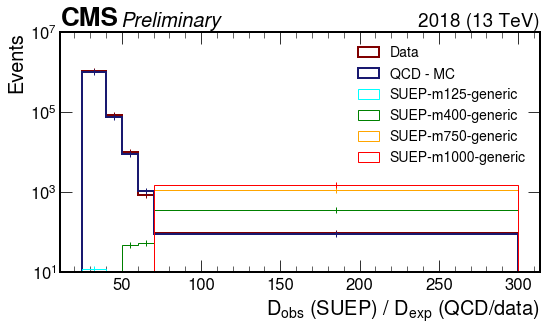

In [214]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
sample = 'generic'
save = False
lumi = 61000

# define figure, axis on which to plot QCD and SUEP
fig, ax = plt.subplots(figsize=(8,5))
hep.cms.label("Preliminary", data=True, year=2018)

# QCD hist for ABCD region
hdata = plots['data']['D_exp_var2_ch']
hQCD_MC = plots['QCD_MC']['D_exp_var2_ch'] * lumi
hM125 = plots['SUEP-m125-generic']['D_obs_var2_ch'] * lumi
hM400 = plots['SUEP-m400-generic']['D_obs_var2_ch'] * lumi
hM700 = plots['SUEP-m750-generic']['D_obs_var2_ch'] * lumi
hM1000 = plots['SUEP-m1000-generic']['D_obs_var2_ch'] * lumi

# plot QCD, sum values and errs
plot1d_bins(hdata, ax, 'Data', color='maroon', lw=2, bins=bins_max)
plot1d_bins(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=2, bins=bins_max)
plot1d_bins(hM125, ax, 'SUEP-m125-generic', lw=1, bins=bins_max)
plot1d_bins(hM400, ax, 'SUEP-m400-generic', lw=1, bins=bins_max)
plot1d_bins(hM700, ax, 'SUEP-m750-generic', lw=1, bins=bins_max)
plot1d_bins(hM1000, ax, 'SUEP-m1000-generic', lw=1, bins=bins_max)

#ax.set_xlim(0,300)
ax.set_ylim(1e1,1e7)
ax.set_yscale('log')
ax.set_xlabel(r"$D_{obs}$ (SUEP) / $D_{exp}$ (QCD/data)")
ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)

if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()